In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install mne

     |████████████████████████████████| 6.8MB 11.9MB/s 


In [ ]:
from mne.datasets.sleep_physionet.age import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, BatchNormalization, UpSampling1D, MaxPooling1D, Flatten, Dense, LeakyReLU, Dropout, Conv1D, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import mne
import numpy as np
import csv
import os
from tensorflow.keras import backend as K

In [ ]:
def build_dataset(no_of_people=20):
  dataset = {'x': [], 'y':[]}
  people = [i for i in range(no_of_people)]
  sf = 100
  annotation_desc_2_event_id = {'Sleep stage W': 1,
                                'Sleep stage 1': 2,
                                'Sleep stage 2': 3,
                                'Sleep stage 3': 4,
                                'Sleep stage 4': 4,
                                'Sleep stage R': 5}
  event_id = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
              'Sleep stage 3/4': 4,
              'Sleep stage R': 5}
  
  tmax = 30. - 1. / sf
  
  files = fetch_data(subjects=people, recording=[1])
  
  count = 0
  for file in files:
      raw = mne.io.read_raw_edf(file[0])
      annot = mne.read_annotations(file[1])
      raw.set_annotations(annot, emit_warning=False)
      events, _ = mne.events_from_annotations(
          raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
      epochs = mne.Epochs(raw=raw, events=events,
                                event_id=event_id, tmin=0., tmax=tmax, baseline=None)
      
      if count == 0:
          X = (epochs.get_data(picks="eeg"))[:,0,:]
          Y = epochs.events[:, 2]
          count += 1
      else:
          x = (epochs.get_data(picks="eeg"))[:,0,:]
          y = epochs.events[:, 2]
          X = np.concatenate((X, x), axis=0)
          Y = np.concatenate((Y, y), axis=0)
      
  #X = (epochs_test.get_data(picks="eeg"))[:,0,:]
  #Y = epochs_test.events[:, 2]
  dataset['x'] = X
  dataset['y'] = Y
  return dataset

In [ ]:
def normalize_vector(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

In [ ]:
dataset = build_dataset(30)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data



Verifying hash adabd3b01fc7bb75c523a974f38ee3ae4e57b40f.



Verifying hash 21c998eadc8b1e3ea6727d3585186b8f76e7e70b.



Verifying hash 4d17451f7847355bcab17584de05e7e1df58c660.



Verifying hash d582a3cbe2db481a362af890bc5a2f5ca7c878dc.



Verifying hash 8b135afa7fb93bb5f1998fda50355944777c245e.



Verifying hash 91043cfe46695088b17b6a02937b25efd674c3fb.



Verifying hash 85e58dc1e3303537dade8c5827ab58328239c384.



Verifying hash 6363d8b0fdc48cf396c9abf054bb4a9696d38bdb.



Verifying hash 04d2b88d25f2ae4a65ba44cd9145bd12800a0e20.



Verifying hash f148821669bd3588187b3b430bd79adf569f86d1.



Verifying hash ea073451b65ce8a6f1a02a8cc2b89d1a162ca0ae.



Verifying hash 4159ef8a3e119d6dcc1bede806f6fbc017b27a0f.



Verifying hash 1736736e585807c14f1ae8bc87a94cae222c5170.



Verifying hash 4bf99622c67c281b25ceccd35e7050328a2946e8.



Verifying hash 1374b34f6139b6ff7e865d8243eef39ba334ef50.



Verifying hash 608024fd19a140ad233a4680e07c2495a74b69c2.



Verifying hash 0e1cc2c4e1da14ab94515e3e7e75e8ad30ec99cb.



Verifying hash 9ec663ffa5c17afcaca59d7829d77b9165102237.



Verifying hash b3502e0bd54683e973182c791aa962b804e79633.



Verifying hash 7aa63b408c769a4a983a908b6ba41d87dd743c6e.



Verifying hash 3ae168ff2c9c0c56f51205fdb10f05a4c6b2064e.



Verifying hash 60d9c3913881e11b06ad99e9870bd1ca4d93c952.



Verifying hash e490956b4dce01c46ba88a2b847f091bb54ea16e.



Verifying hash 12db1920e2f6083c8ab1f2c24fe35dfa03715e4a.



Verifying hash 33c72025a7a215ea5e255f4254cb0f93b1313369.



Verifying hash daa57ece807cb5325c6d1ce059f0e8a8d1c85391.



Verifying hash 42ff97035aae6dd34ca9437857c48ac6f2ab97df.



Verifying hash 5beef85170bdbb5cf2eea24a79f0f5c2c3975c4b.



Verifying hash 83493e1c32d441c9e5ee3de6a024bfb5e7ab9f5f.



Verifying hash 511d398f22b9b2b304de27c40740a41584ff6af2.



Verifying hash 5a92d49699d4de369d66d9462e91b0dcb3312649.



Verifying hash 37dcbd339c95322d028b3a5466812697041cc373.



Verifying hash e56ff3aa366fe9a04a0fdfdd4cd862e77e8ac807.



Verifying hash 56711b1bfed292032491f5cce57494629286a131.



Verifying hash f1a65522cb7d6c71ac47742535a12c88e2019dad.



Verifying hash dd257c8d922f08c2c8ca5236c9bf54da887c68e5.



Verifying hash 23674d20572853eb6d988d24378c52123f66500c.



Verifying hash 51fc3df2df7d4da654f3e18ed1b233d0c60cfa80.



Verifying hash d6da621dbb20dec3494a38c7d2a0363793ac5ebe.



Verifying hash defc7b9368c2d3c4ab4a294757843825a83cdb5d.



Verifying hash 38a0be6e45ddd9b1f17d09964a32e005dc5a6519.



Verifying hash 83822f9970d3959ad2e0613492ae39bd0fae6068.



Verifying hash c106ad072dbc975a3742f7eff151219870f0c794.



Verifying hash 9126937ea8a414d6ae9bc4a4194d841a891fa8a8.



Verifying hash 8733ea022d3778259a436507156cf3360ad8be06.



Verifying hash b158eda4f81772095c129be77f8e60ec9d81b884.



Verifying hash d96f1f35b2f77c7de706036c6e4114139e07b307.



Verifying hash 9f6df70676d6cddcf069ceb7f408a7989af99ce2.



Verifying hash 58719e53fe18d2fc4cb1776ab5d43306beb1325d.



Verifying hash fb1432e303a8f99a2256ce682db95d88772c479f.



Verifying hash 7dbc0289707ff70662d367d65de7bec188484d1b.



Verifying hash e38be8134e4a36eb418ca1f06a1fe02b52d0ebf1.



Verifying hash b81c9bd1875b33713b5eb56b58f1e120841b507f.



Verifying hash 501eda59557bb99d530d01bdad3579f1e1158991.



Verifying hash 20994715d34edb26113180ee330ce287dbf57b60.



Verifying hash 26c5c7f3a5c350d3505af2857835ce81252c5990.



Verifying hash 51811913d7854f95c319076e670d988687ca667c.



Verifying hash d188150831e912081dbeda2695231177200c39f9.



Verifying hash f81c7574a5e5829e006d0b705bf5208a3349c9c7.



Verifying hash 577c1345f6d070d975db5016048722f78b1b414e.
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
2650 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2650 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
2802 matching events found
No baseline correction applied
0 projection items ac

In [ ]:
print(dataset['x'].shape, dataset['x'].dtype)
print(dataset['y'].shape, dataset['y'].dtype)

(81882, 3000) float64
(81882,) int64


In [ ]:
def preprocess_dataset(dataset, test_size=0.1, val_size=0.2):
  x = np.array([normalize_vector(i) for i in dataset['x']], dtype=np.float)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  y = np.array(dataset['y'], dtype=np.uint8)

  ohe = OneHotEncoder()
  y = ohe.fit_transform(y.reshape((-1,1))).toarray()
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42)

  print(x_train.shape, y_train.shape)
  print(x_val.shape, y_val.shape)
  print(x_test.shape, y_test.shape)

  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_dataset(dataset, 0.2, 0.3)

(45853, 3000, 1) (45853, 5)
(19652, 3000, 1) (19652, 5)
(16377, 3000, 1) (16377, 5)


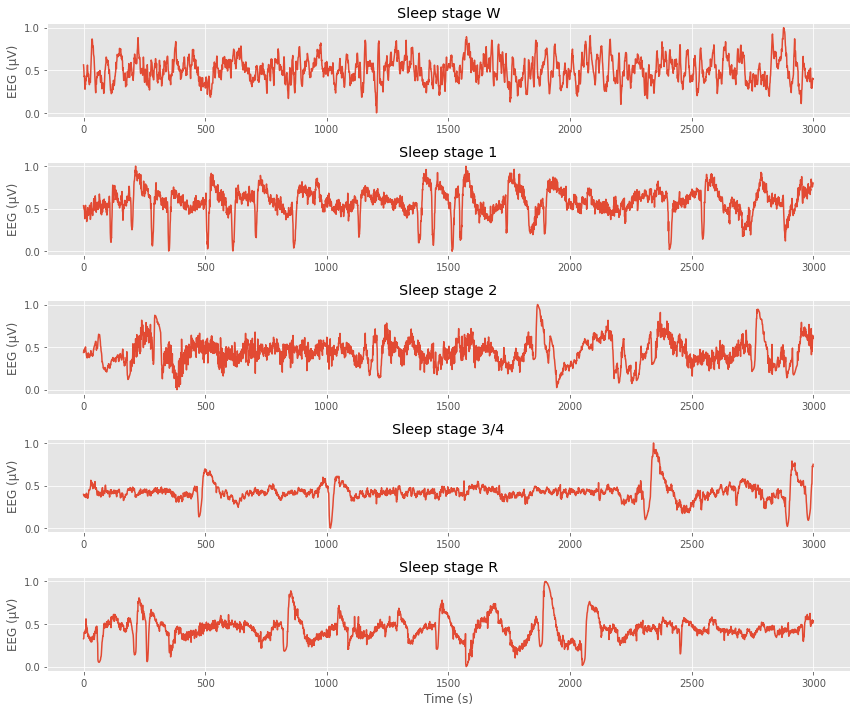

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=[12, 10])

fig.add_subplot(5,1,1)
plt.plot(x_train[40643])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage W")

fig.add_subplot(5,1,2)
plt.plot(x_train[40644])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 1")

fig.add_subplot(5,1,3)
plt.plot(x_train[40642])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 2")

fig.add_subplot(5,1,4)
plt.plot(x_train[40646])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 3/4")

fig.add_subplot(5,1,5)
plt.plot(x_train[40637])
plt.xlabel('Time (s)')
plt.ylabel('EEG (μV)')
plt.title("Sleep stage R")

plt.tight_layout()
plt.show()

In [ ]:
def build_model(time_steps, features, latent_dim=128):
  i = Input(shape=(time_steps, features))
  x = i

  x = Conv1D(16, 3, strides=1, padding='same', dilation_rate=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Conv1D(32, 3, strides=1, padding='same', dilation_rate=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Conv1D(64, 3, strides=1, padding='same', dilation_rate=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  volume_size = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latent_dim)(x)

  encoder = Model(i, latent, name="encoder")

  latent_inputs = Input(shape=(latent_dim,))
  x = Dense(np.prod(volume_size[1:]))(latent_inputs)
  x = Reshape((volume_size[1], volume_size[2]))(x)

  x = Conv1D(64, 3, padding='same', dilation_rate=2)(x)
  x = UpSampling1D(size=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(32, 3, padding='same', dilation_rate=2)(x)
  x = UpSampling1D(size=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(16, 3, padding='same', dilation_rate=2)(x)
  x = UpSampling1D(size=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  o = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

  decoder = Model(latent_inputs, o, name="decoder")

  autoencoder = Model(i, decoder(encoder(i)), name="autoencoder")
  return (encoder, decoder, autoencoder)

In [ ]:
(encoder, decoder, autoencoder) = build_model(3000, 1, 512)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3000, 1)]         0         
_________________________________________________________________
encoder (Functional)         (None, 512)               12296800  
_________________________________________________________________
decoder (Functional)         (None, 3000, 1)           12332577  
Total params: 24,629,377
Trainable params: 24,628,929
Non-trainable params: 448
_________________________________________________________________


In [ ]:
INIT_LR = 0.0005
EPOCHS = 15
BATCH_SIZE = 16
STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_val.shape[0] // BATCH_SIZE

def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

callbacks = [LearningRateScheduler(poly_decay)]

In [ ]:
def acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

opt = Adam(lr=INIT_LR, amsgrad=True)

In [ ]:
autoencoder.compile(loss=root_mean_squared_error, optimizer=opt, metrics=[acc])

In [ ]:
r = autoencoder.fit(
  x_train, x_train,
  validation_data=(x_val, x_val),
  epochs=EPOCHS, batch_size=BATCH_SIZE,
  callbacks=callbacks
)

Epoch 1/15
2866/2866 [==============================] - 129s 45ms/step - loss: 0.0697 - acc: 0.8497 - val_loss: 0.0576 - val_acc: 0.8817
Epoch 2/15
2866/2866 [==============================] - 129s 45ms/step - loss: 0.0565 - acc: 0.8806 - val_loss: 0.0542 - val_acc: 0.8906
Epoch 3/15
2866/2866 [==============================] - 128s 45ms/step - loss: 0.0543 - acc: 0.8859 - val_loss: 0.0528 - val_acc: 0.8942
Epoch 4/15
2866/2866 [==============================] - 128s 45ms/step - loss: 0.0529 - acc: 0.8893 - val_loss: 0.0518 - val_acc: 0.8971
Epoch 5/15
2866/2866 [==============================] - 128s 45ms/step - loss: 0.0519 - acc: 0.8918 - val_loss: 0.0509 - val_acc: 0.8995
Epoch 6/15
2866/2866 [==============================] - 127s 44ms/step - loss: 0.0513 - acc: 0.8937 - val_loss: 0.0504 - val_acc: 0.9008
Epoch 7/15
2866/2866 [==============================] - 127s 44ms/step - loss: 0.0508 - acc: 0.8947 - val_loss: 0.0500 - val_acc: 0.9017
Epoch 8/15
2866/2866 [===================

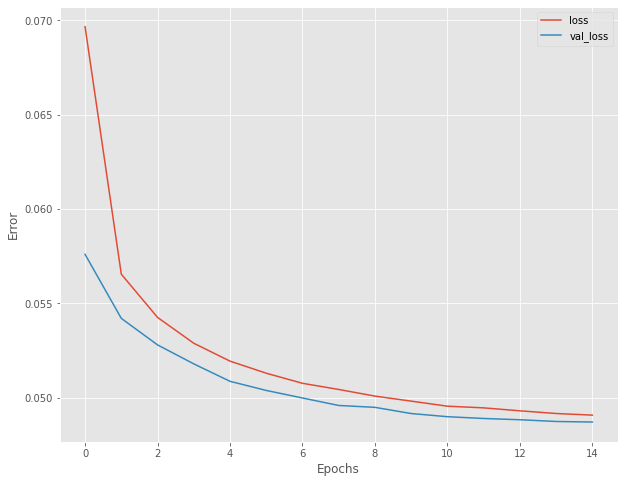

In [ ]:
  plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

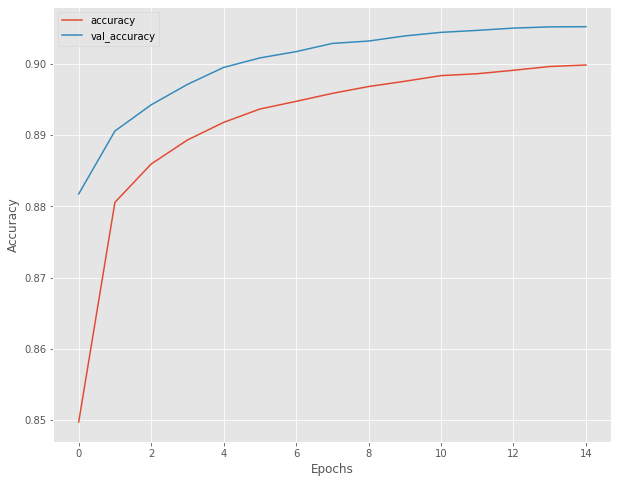

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['acc'], label='accuracy')
plt.plot(r.history['val_acc'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

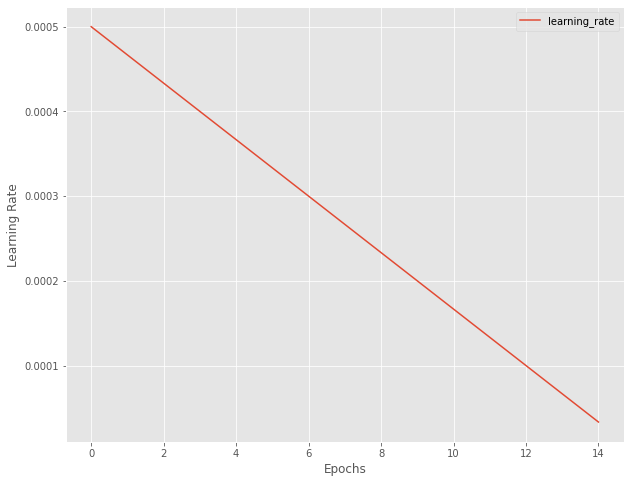

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['lr'], label='learning_rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend(loc='best')
plt.show()

In [ ]:
print(autoencoder.evaluate(x_test, x_test, batch_size=BATCH_SIZE))

1024/1024 [==============================] - 6s 6ms/step - loss: 0.0480 - acc: 0.9063
[0.04796900600194931, 0.9063431024551392]


In [ ]:
preds = autoencoder.predict(x_test)
print(preds.shape)

(16377, 3000, 1)


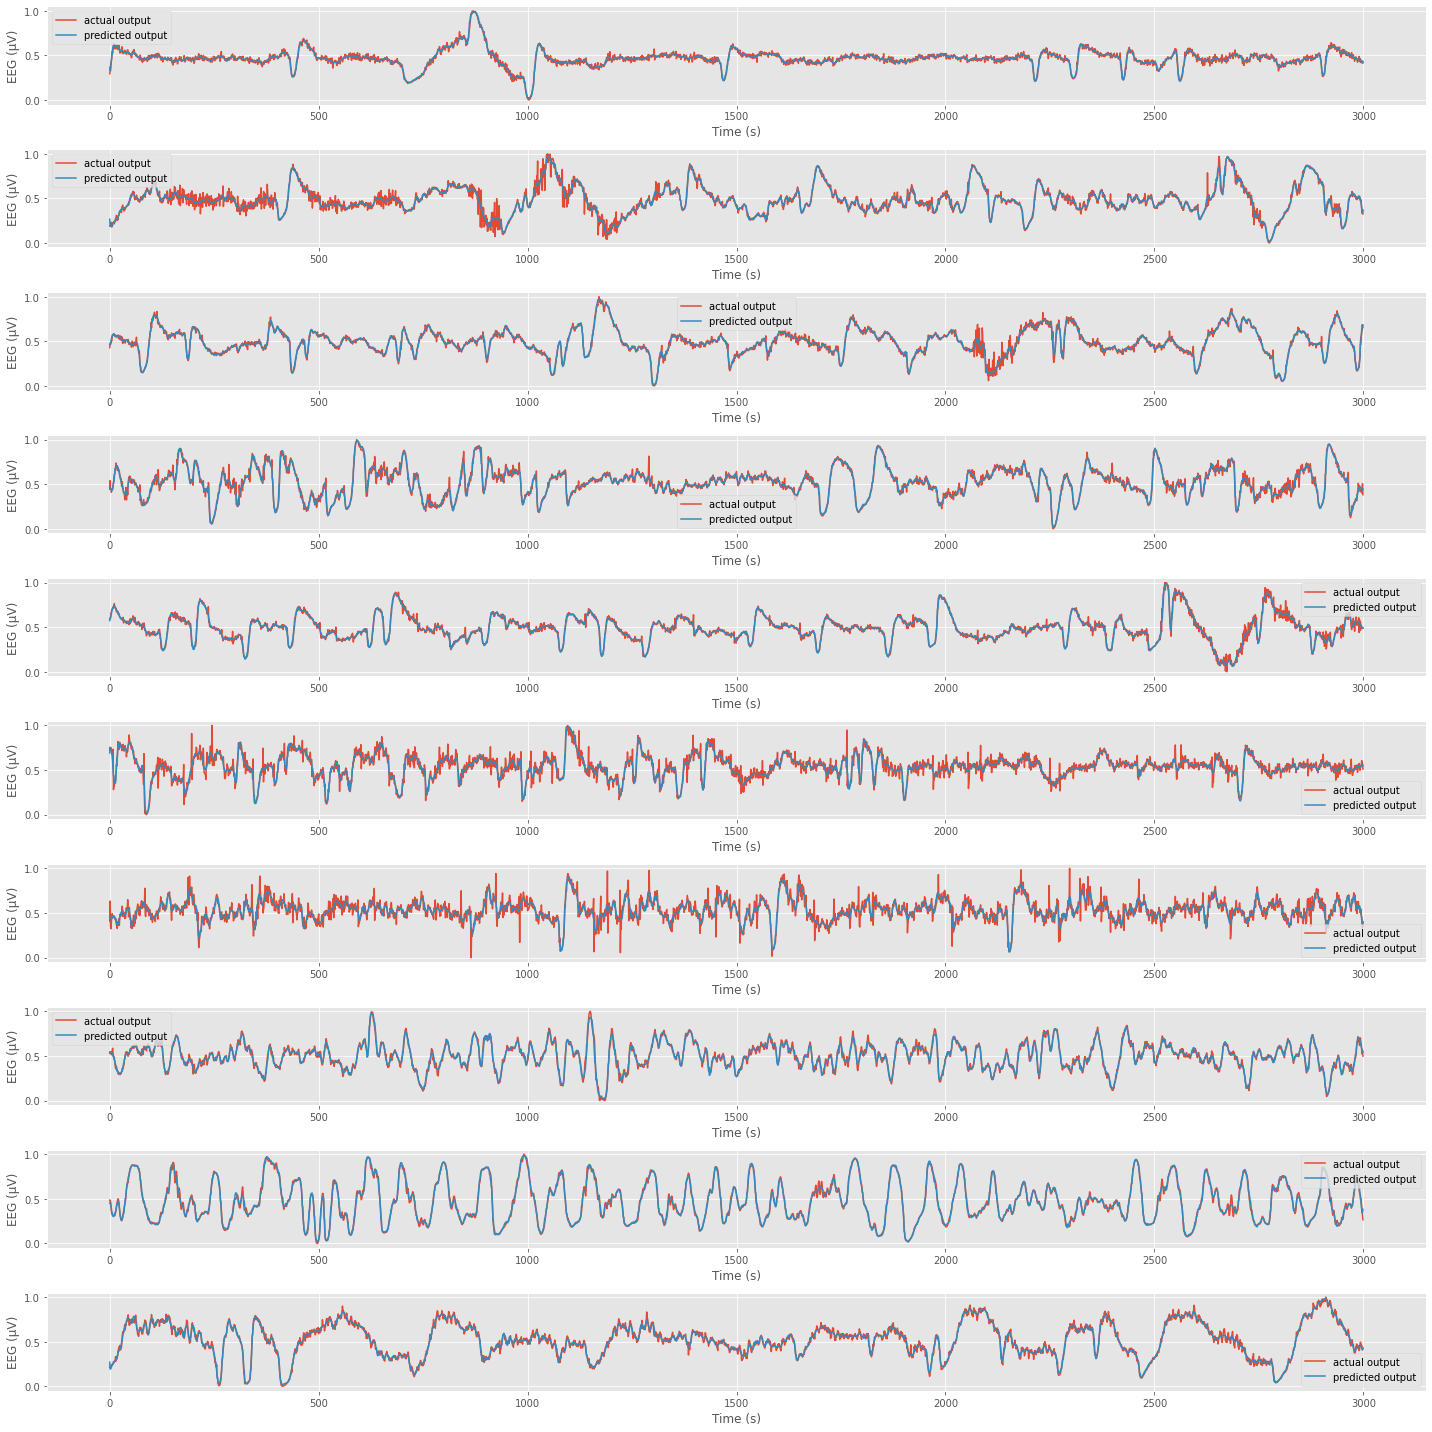

In [ ]:
x = 10

preds_index = np.random.randint(0, x_test.shape[0], x)

plt.style.use('ggplot')
fig = plt.figure(figsize=[20, 20])

for i,v in enumerate(preds_index):
  fig.add_subplot(x,1,i+1)
  plt.plot(x_test[v], label="actual output")
  plt.plot(preds[v], label="predicted output")
  plt.ylabel('EEG (μV)')
  plt.xlabel('Time (s)')
  plt.legend(loc="best")

plt.tight_layout()
plt.show()